A. Knowledge Graph

In [1]:
!pip -q install -U datasets transformers sentencepiece

import os, json, random, re, math
from collections import Counter, defaultdict
import numpy as np

BASE_DIR = "/content/webnlg_kg_text2kg_1000"
os.makedirs(BASE_DIR, exist_ok=True)

OUT_PAIRS   = os.path.join(BASE_DIR, "pairs_train_10016.json")
OUT_ALIGNED = os.path.join(BASE_DIR, "text2kg_aligned_train_10016.json")
OUT_SSC     = os.path.join(BASE_DIR, "kg_triples_ssc_train_10016.json")

SEED = 42
random.seed(SEED)

# ---------- load WebNLG (Orange/webnlg-qa가 너 환경에서 이미 동작했었음) ----------
from datasets import load_dataset
ds = load_dataset("Orange/webnlg-qa", split="train")   # rows=10016
print("rows:", len(ds))
print("keys:", ds.column_names)

def pick_text(row):
    # row["lex"]["text"]는 list 형태
    lex = row.get("lex", {})
    texts = lex.get("text", []) if isinstance(lex, dict) else []
    if texts and isinstance(texts, list):
        return texts[0]
    return ""

def pick_triples(row):
    # row["modified_triple_sets"]가 list[dict{subject,property,object}]
    triples = row.get("modified_triple_sets", [])
    out=[]
    for tri in triples:
        if isinstance(tri, dict):
            h = tri.get("subject"); r = tri.get("property"); t = tri.get("object")
            if h is not None and r is not None and t is not None:
                out.append([h, r, t])
        elif isinstance(tri, (list, tuple)) and len(tri) >= 3:
            out.append([tri[0], tri[1], tri[2]])
    return out

pairs=[]
for i in range(len(ds)):
    row = ds[i]
    text = pick_text(row)
    triples = pick_triples(row)
    if text.strip() and len(triples)>0:
        pairs.append({"idx": int(row.get("id", i)), "text": text, "triples": triples})

print("pairs:", len(pairs))
with open(OUT_PAIRS, "w", encoding="utf-8") as f:
    json.dump(pairs, f, ensure_ascii=False, indent=2)
print("saved:", OUT_PAIRS)

# ---------- Text2KG alignment (Table I 스타일) ----------
def _strip_uri_datatype(x: str) -> str:
    x = str(x).strip()
    if "^^<" in x:
        x = x.split("^^<")[0].strip()
    return x

def norm_entity(x: str) -> str:
    x = _strip_uri_datatype(x)
    x = x.replace("_"," ").replace('"',"").strip()
    x = re.sub(r"^<http[^>]+/([^/>]+)>$", r"\1", x)
    x = re.sub(r"\s+"," ", x)
    return x.lower()

def align_triples_by_contains(text: str, triples):
    s = text.lower()
    out=[]
    for h,r,t in triples:
        hh = norm_entity(h); tt = norm_entity(t)
        # 논문 Table I 조건: sentence contains(h) and contains(t)
        if hh and tt and (hh in s) and (tt in s):
            out.append([h,r,t])
    return out

aligned=[]
for ex in pairs:
    at = align_triples_by_contains(ex["text"], ex["triples"])
    aligned.append({"idx": ex["idx"], "aligned_triples": at, "gold_triples": ex["triples"]})

with open(OUT_ALIGNED, "w", encoding="utf-8") as f:
    json.dump(aligned, f, ensure_ascii=False, indent=2)
print("saved:", OUT_ALIGNED)

# ---------- SSC (dictionary + fixed-length binary) ----------
# 1) vocab 만들기
ents=set()
rels=set()
all_triples=[]
for ex in pairs:
    for h,r,t in ex["triples"]:
        ents.add(_strip_uri_datatype(h))
        ents.add(_strip_uri_datatype(t))
        rels.add(str(r))
        all_triples.append([h,r,t])

ent2id = {e:i for i,e in enumerate(sorted(ents))}
rel2id = {r:i for i,r in enumerate(sorted(rels))}
# triple code length bits
B_ent = int(math.ceil(math.log2(len(ent2id)+1)))
B_rel = int(math.ceil(math.log2(len(rel2id)+1)))
L = B_ent + B_rel + B_ent
print("vocab ents:", len(ent2id), "rels:", len(rel2id))
print("bits:", "B_ent", B_ent, "B_rel", B_rel, "L", L)

def int_to_bits(x, width):
    return [(x >> k) & 1 for k in range(width-1, -1, -1)]

def triple_to_bits(tri):
    h,r,t = tri
    hid = ent2id[_strip_uri_datatype(h)]
    rid = rel2id[str(r)]
    tid = ent2id[_strip_uri_datatype(t)]
    bits = int_to_bits(hid, B_ent) + int_to_bits(rid, B_rel) + int_to_bits(tid, B_ent)
    return bits

# unique triples만 SSC에 저장
seen=set()
ssc=[]
for h,r,t in all_triples:
    key=(h,r,t)
    if key in seen:
        continue
    seen.add(key)
    ssc.append({"triple":[h,r,t], "bits": triple_to_bits([h,r,t])})

with open(OUT_SSC, "w", encoding="utf-8") as f:
    json.dump(ssc, f, ensure_ascii=False, indent=2)
print("unique triples:", len(ssc))
print("saved:", OUT_SSC)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 154.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 50.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-e897795f3aafe8(…):   0%|          | 0.00/7.53M [00:00<?, ?B/s]

data/validation-00000-of-00001-84293abb0(…):   0%|          | 0.00/1.02M [00:00<?, ?B/s]

data/test-00000-of-00001-b4a73206fd8f888(…):   0%|          | 0.00/933k [00:00<?, ?B/s]

data/challenge-00000-of-00001-c014a25bbb(…):   0%|          | 0.00/155k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10016 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1264 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1417 [00:00<?, ? examples/s]

Generating challenge split:   0%|          | 0/100 [00:00<?, ? examples/s]

rows: 10016
keys: ['category', 'size', 'id', 'eid', 'original_triple_sets', 'modified_triple_sets', 'shape', 'shape_type', 'lex', 'test_category', 'dbpedia_links', 'links', 'graph', 'main_entity', 'mappings', 'dialogue']
pairs: 10016
saved: /content/webnlg_kg_text2kg_1000/pairs_train_10016.json
saved: /content/webnlg_kg_text2kg_1000/text2kg_aligned_train_10016.json
vocab ents: 3131 rels: 364
bits: B_ent 12 B_rel 9 L 33
unique triples: 3687
saved: /content/webnlg_kg_text2kg_1000/kg_triples_ssc_train_10016.json


B. Semantic Symbol Abstraction

In [6]:
import os, json, re
from collections import defaultdict
from tqdm import tqdm

KG_PATH    = "/content/webnlg_kg_text2kg_1000/kg_triples_ssc_train_10016.json"
PAIRS_PATH = "/content/webnlg_kg_text2kg_1000/pairs_train_10016.json"
OUT_PATH   = "/content/webnlg_kg_text2kg_1000/semantic_symbol_abstraction_train_10016.json"

assert os.path.exists(KG_PATH), KG_PATH
assert os.path.exists(PAIRS_PATH), PAIRS_PATH

with open(KG_PATH, "r", encoding="utf-8") as f:
    kg_triples = json.load(f)   # each: {"triple":[h,r,t], "bits":[...]}
with open(PAIRS_PATH, "r", encoding="utf-8") as f:
    pairs = json.load(f)        # each: {"idx":..., "text":..., "triples":[...]}

print("KG:", KG_PATH)
print("Pairs:", PAIRS_PATH)
print("KG triples:", len(kg_triples))
print("Pairs:", len(pairs))

# -------------------------
# Normalization (match-friendly)
# -------------------------
def strip_datatype(x: str) -> str:
    x = str(x).strip()
    if "^^<" in x:
        x = x.split("^^<")[0].strip()
    return x

def norm(x: str) -> str:
    x = strip_datatype(x)
    x = x.replace("_", " ").replace('"', " ").strip()
    x = re.sub(r"^<http[^>]+/([^/>]+)>$", r"\1", x)
    x = re.sub(r"\s+", " ", x)
    return x.lower()

# -------------------------
# Build head index
# -------------------------
head_index = defaultdict(list)

# ✅ FIX: tr["h"]가 아니라 tr["triple"][0]을 head로
for tr in kg_triples:
    if "triple" not in tr or not isinstance(tr["triple"], list) or len(tr["triple"]) < 3:
        continue
    h, r, t = tr["triple"][0], tr["triple"][1], tr["triple"][2]
    head_index[norm(h)].append(tr)

all_heads = list(head_index.keys())
print("Unique heads indexed:", len(all_heads))

# -------------------------
# Text2KG-style alignment (Table I)
# - for each sentence s
# - for each triple(h,r,t) in KG
#   if s contains h and s contains t => select
#
# But brute force is huge, so we:
#  1) find which KG heads appear in s (via simple scan)
#  2) only test triples under those heads
# -------------------------
def find_candidate_heads_in_text(s_norm: str, heads: list):
    # 간단 버전: head 문자열이 text에 포함되는지 체크
    # (더 빠르게 하려면 Aho-corasick 같은 걸 쓰지만, 우선은 이걸로 충분)
    cand = []
    for h in heads:
        if h and h in s_norm:
            cand.append(h)
    return cand

results = []
skipped_no_head = 0

# heads가 너무 많으면 포함 체크가 느릴 수 있어서
# head 길이가 짧은 것들(예: 1~2글자)은 오탐 많아 제외하는 옵션
MIN_HEAD_LEN = 3

heads_filtered = [h for h in all_heads if len(h) >= MIN_HEAD_LEN]

for ex in tqdm(pairs, total=len(pairs)):
    idx = ex.get("idx")
    text = ex.get("text", "")
    s_norm = norm(text)

    cand_heads = find_candidate_heads_in_text(s_norm, heads_filtered)
    if not cand_heads:
        skipped_no_head += 1
        results.append({
            "idx": idx,
            "text": text,
            "semantic_symbols": [],   # aligned triples (KG 기준)
        })
        continue

    aligned = []
    for h in cand_heads:
        for tr in head_index[h]:
            hh, rr, tt = tr["triple"]
            # Table I 조건: s.contains(h) AND s.contains(t)
            if norm(tt) in s_norm:
                aligned.append({
                    "triple": tr["triple"],
                    "bits": tr["bits"]
                })

    results.append({
        "idx": idx,
        "text": text,
        "semantic_symbols": aligned
    })

print("Skipped (no head found):", skipped_no_head, "/", len(pairs))

with open(OUT_PATH, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print("Saved:", OUT_PATH)

# quick sanity check
nonempty = sum(1 for x in results if len(x["semantic_symbols"]) > 0)
print("Non-empty semantic symbols:", nonempty, "/", len(results))
print("Example non-empty:")
for x in results:
    if x["semantic_symbols"]:
        print("idx:", x["idx"])
        print("text:", x["text"][:160])
        print("first symbol:", x["semantic_symbols"][0]["triple"])
        break


KG: /content/webnlg_kg_text2kg_1000/kg_triples_ssc_train_10016.json
Pairs: /content/webnlg_kg_text2kg_1000/pairs_train_10016.json
KG triples: 3687
Pairs: 10016
Unique heads indexed: 718


100%|██████████| 10016/10016 [00:02<00:00, 4287.29it/s]


Skipped (no head found): 242 / 10016
Saved: /content/webnlg_kg_text2kg_1000/semantic_symbol_abstraction_train_10016.json
Non-empty semantic symbols: 8858 / 10016
Example non-empty:
idx: 7367
text: Rome is the capital of Italy, where Matteo Renzi is a leader, and where Amatriciana sauce can be found.
first symbol: ['Italy', 'capital', 'Rome']


C. Conventional Communication Modules

semantic symbol coding

In [9]:
import os, json, math, re
from collections import defaultdict
from tqdm import tqdm

BASE_DIR = "/content/webnlg_kg_text2kg_1000"

# ✅ 너가 지금 만든 10k(train=10016) 파일들
KG_SSC_PATH = os.path.join(BASE_DIR, "kg_triples_ssc_train_10016.json")
B_OUT_PATH  = os.path.join(BASE_DIR, "semantic_symbol_abstraction_train_10016.json")

assert os.path.exists(KG_SSC_PATH), f"Missing: {KG_SSC_PATH}"
assert os.path.exists(B_OUT_PATH),  f"Missing: {B_OUT_PATH}"

with open(KG_SSC_PATH, "r", encoding="utf-8") as f:
    kg_ssc = json.load(f)  # each: {"triple":[h,r,t], "bits":[...]}
with open(B_OUT_PATH, "r", encoding="utf-8") as f:
    abstr = json.load(f)   # each: {"idx","text","semantic_symbols":[{"triple":[...],"bits":[...]}]}

print("KG:", KG_SSC_PATH)
print("B out:", B_OUT_PATH)
print("KG triples:", len(kg_ssc))
print("B items:", len(abstr))

# -------------------------
# normalize (dictionary key 안정화용)
# -------------------------
def strip_datatype(x: str) -> str:
    x = str(x).strip()
    if "^^<" in x:
        x = x.split("^^<")[0].strip()
    return x

def norm_key(x: str) -> str:
    x = strip_datatype(x)
    x = x.replace("_"," ").replace('"'," ").strip()
    x = re.sub(r"^<http[^>]+/([^/>]+)>$", r"\1", x)
    x = re.sub(r"\s+"," ", x)
    return x.lower()

def norm_triple_key(tri):
    h,r,t = tri
    return (norm_key(h), norm_key(r), norm_key(t))

# -------------------------
# 1) Build dictionaries: entity2id, rel2id
# -------------------------
entities=set()
relations=set()

for it in kg_ssc:
    tri = it.get("triple", None)
    if not tri or len(tri) < 3:
        continue
    h,r,t = tri[0], tri[1], tri[2]
    entities.add(strip_datatype(h))
    entities.add(strip_datatype(t))
    relations.add(str(r))

entities = sorted(list(entities))
relations = sorted(list(relations))

entity2id = {e:i for i,e in enumerate(entities)}
rel2id    = {r:i for i,r in enumerate(relations)}

print("Num entities:", len(entity2id))
print("Num relations:", len(rel2id))

# bit-length (fixed)
bE = math.ceil(math.log2(len(entity2id))) if len(entity2id) > 1 else 1
bR = math.ceil(math.log2(len(rel2id))) if len(rel2id) > 1 else 1
print("Bits per entity:", bE, "| Bits per relation:", bR, "| Total bits per triple:", 2*bE + bR)

# save dicts
with open(os.path.join(BASE_DIR, "entity2id_train_10016.json"), "w", encoding="utf-8") as f:
    json.dump(entity2id, f, ensure_ascii=False, indent=2)
with open(os.path.join(BASE_DIR, "rel2id_train_10016.json"), "w", encoding="utf-8") as f:
    json.dump(rel2id, f, ensure_ascii=False, indent=2)

print("Saved dictionaries:",
      os.path.join(BASE_DIR, "entity2id_train_10016.json"),
      os.path.join(BASE_DIR, "rel2id_train_10016.json"))

# -------------------------
# 2) Attach integer ids to KG SSC
#    (bits는 기존 파일 것을 그대로 사용)
# -------------------------
def triple_to_ids(tri):
    h,r,t = tri
    h = strip_datatype(h); t = strip_datatype(t)
    r = str(r)
    return int(entity2id[h]), int(rel2id[r]), int(entity2id[t])

kg_ssc_with_ids = []
# lookup: norm triple -> (bits, raw triple)
kg_lookup = {}
for it in kg_ssc:
    tri = it["triple"]
    key = norm_triple_key(tri)
    kg_lookup[key] = {"bits": it["bits"], "triple": tri}

for it in kg_ssc:
    tri = it["triple"]
    hid, rid, tid = triple_to_ids(tri)
    kg_ssc_with_ids.append({
        "triple": tri,
        "hid": hid, "rid": rid, "tid": tid,
        "bits": it["bits"]
    })

OUT_KG_SSC_IDS = os.path.join(BASE_DIR, "kg_triples_ssc_with_ids_train_10016.json")
with open(OUT_KG_SSC_IDS, "w", encoding="utf-8") as f:
    json.dump(kg_ssc_with_ids, f, ensure_ascii=False, indent=2)

print("Saved:", OUT_KG_SSC_IDS)

# -------------------------
# 3) Attach ids (and fill missing bits) to B output
# -------------------------
fixed = 0
missing = 0

for ex in abstr:
    new_syms=[]
    for sym in ex.get("semantic_symbols", []):
        tri = sym.get("triple", None)
        if not tri or len(tri) < 3:
            continue

        # bits가 없으면 KG에서 채워줌
        bits = sym.get("bits", None)
        if bits is None:
            key = norm_triple_key(tri)
            if key in kg_lookup:
                bits = kg_lookup[key]["bits"]
                fixed += 1
            else:
                missing += 1
                continue

        hid, rid, tid = triple_to_ids(tri)
        new_syms.append({
            "triple": tri,
            "hid": hid, "rid": rid, "tid": tid,
            "bits": bits
        })
    ex["semantic_symbols_ssc"] = new_syms

OUT_ABSTR_SSC = os.path.join(BASE_DIR, "semantic_symbol_abstraction_ssc_train_10016.json")
with open(OUT_ABSTR_SSC, "w", encoding="utf-8") as f:
    json.dump(abstr, f, ensure_ascii=False, indent=2)

print("Saved:", OUT_ABSTR_SSC)
print("Filled missing bits from KG:", fixed)
print("Missing triples not found in KG:", missing)

# sanity
for ex in abstr:
    if ex.get("semantic_symbols_ssc"):
        print("\n--- SANITY ---")
        print("idx:", ex.get("idx"))
        print("text:", ex.get("text","")[:120])
        print("first symbol:", ex["semantic_symbols_ssc"][0])
        break


KG: /content/webnlg_kg_text2kg_1000/kg_triples_ssc_train_10016.json
B out: /content/webnlg_kg_text2kg_1000/semantic_symbol_abstraction_train_10016.json
KG triples: 3687
B items: 10016
Num entities: 3131
Num relations: 364
Bits per entity: 12 | Bits per relation: 9 | Total bits per triple: 33
Saved dictionaries: /content/webnlg_kg_text2kg_1000/entity2id_train_10016.json /content/webnlg_kg_text2kg_1000/rel2id_train_10016.json
Saved: /content/webnlg_kg_text2kg_1000/kg_triples_ssc_with_ids_train_10016.json
Saved: /content/webnlg_kg_text2kg_1000/semantic_symbol_abstraction_ssc_train_10016.json
Filled missing bits from KG: 0
Missing triples not found in KG: 0

--- SANITY ---
idx: 7367
text: Rome is the capital of Italy, where Matteo Renzi is a leader, and where Amatriciana sauce can be found.
first symbol: {'triple': ['Italy', 'capital', 'Rome'], 'hid': 2164, 'rid': 62, 'tid': 2737, 'bits': [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]}


channel coding, channel, channel
decoding

In [11]:
import os, json, numpy as np
from tqdm import tqdm

BASE_DIR = "/content/webnlg_kg_text2kg_1000"

ABSTR_SSC_PATH   = os.path.join(BASE_DIR, "semantic_symbol_abstraction_ssc_train_10016.json")
KG_SSC_IDS_PATH  = os.path.join(BASE_DIR, "kg_triples_ssc_with_ids_train_10016.json")

assert os.path.exists(ABSTR_SSC_PATH), ABSTR_SSC_PATH
assert os.path.exists(KG_SSC_IDS_PATH), KG_SSC_IDS_PATH

with open(ABSTR_SSC_PATH, "r", encoding="utf-8") as f:
    abstr = json.load(f)   # each: {"idx","text",...,"semantic_symbols_ssc":[{triple,hid,rid,tid,bits}]}
with open(KG_SSC_IDS_PATH, "r", encoding="utf-8") as f:
    kg = json.load(f)      # each: {"triple":[h,r,t], "hid","rid","tid","bits"}

L = len(kg[0]["bits"])
print("Loaded abstr:", len(abstr))
print("Loaded KG:", len(kg))
print("SSC bits length L:", L)

# -------------------------
# D parameters
# -------------------------
P = 0.10         # BSC error prob (원하면 0.0~0.2로 바꿔)
REP = 3          # repetition code
OUT_PATH = os.path.join(BASE_DIR, f"channel_decoded_symbols_train_10016_p{int(P*100):02d}_rep{REP}.json")

# -------------------------
# Channel coding / channel / decoding
# -------------------------
def rep_encode(bits: np.ndarray, rep=3) -> np.ndarray:
    return np.repeat(bits, rep).astype(np.int8)

def rep_decode(bits: np.ndarray, rep=3) -> np.ndarray:
    n = (bits.size // rep) * rep
    bits = bits[:n].reshape(-1, rep)
    return (np.sum(bits, axis=1) >= (rep/2)).astype(np.int8)

def bsc(bits: np.ndarray, p: float) -> np.ndarray:
    flip = (np.random.rand(bits.size) < p).astype(np.int8)
    return (bits ^ flip).astype(np.int8)

# -------------------------
# Build KG codebook arrays for correction
# -------------------------
KG_BITS = np.array([it["bits"] for it in kg], dtype=np.int8)

# bits -> triple/ids 역매핑 (bits는 list라 tuple로)
bits2meta = {}
for it in kg:
    bits2meta[tuple(it["bits"])] = {
        "triple": it["triple"],
        "hid": it["hid"], "rid": it["rid"], "tid": it["tid"],
        "bits": it["bits"]
    }

def correction(o_bits: np.ndarray) -> dict:
    """
    Table II의 'most similar semantic symbol'을 구현.
    - 논문 문맥상: Hamming distance 최소가 가장 유사.
    """
    # brute-force Hamming to all KG codes
    dists = np.sum(KG_BITS != o_bits[None, :], axis=1)
    best = int(np.argmin(dists))
    best_bits = tuple(KG_BITS[best].tolist())
    return bits2meta[best_bits]

# -------------------------
# Run over dataset (D)
# -------------------------
out = []
empty_in = 0
empty_out = 0

for ex in tqdm(abstr, total=len(abstr)):
    syms = ex.get("semantic_symbols_ssc", [])
    if not syms:
        empty_in += 1
        out.append({
            "idx": ex.get("idx"),
            "text": ex.get("text"),
            "decoded_symbols": []
        })
        continue

    decoded = []
    for s in syms:
        b = np.array(s["bits"], dtype=np.int8)
        tx = rep_encode(b, rep=REP)
        rx = bsc(tx, P)
        o  = rep_decode(rx, rep=REP)

        meta = correction(o)  # corrected symbol from KG
        decoded.append(meta)

    if not decoded:
        empty_out += 1

    out.append({
        "idx": ex.get("idx"),
        "text": ex.get("text"),
        "decoded_symbols": decoded
    })

with open(OUT_PATH, "w", encoding="utf-8") as f:
    json.dump(out, f, ensure_ascii=False, indent=2)

print("\nSaved:", OUT_PATH)
print("Empty input (no symbols):", empty_in, "/", len(abstr))
print("Empty output (after decode):", empty_out, "/", len(abstr))

# -------------------------
# Demo print (1 example)
# -------------------------
for ex in out:
    if ex["decoded_symbols"]:
        print("\n==== DEMO (D output) ====")
        print("idx:", ex["idx"])
        print("text:", (ex["text"] or "")[:200])
        print("decoded_symbols count:", len(ex["decoded_symbols"]))
        print("first decoded triple:", ex["decoded_symbols"][0]["triple"])
        print("first decoded ids:", (ex["decoded_symbols"][0]["hid"], ex["decoded_symbols"][0]["rid"], ex["decoded_symbols"][0]["tid"]))
        break


Loaded abstr: 10016
Loaded KG: 3687
SSC bits length L: 33


100%|██████████| 10016/10016 [00:07<00:00, 1279.16it/s]



Saved: /content/webnlg_kg_text2kg_1000/channel_decoded_symbols_train_10016_p10_rep3.json
Empty input (no symbols): 1158 / 10016
Empty output (after decode): 0 / 10016

==== DEMO (D output) ====
idx: 7367
text: Rome is the capital of Italy, where Matteo Renzi is a leader, and where Amatriciana sauce can be found.
decoded_symbols count: 3
first decoded triple: ['Italy', 'capital', 'Rome']
first decoded ids: (2164, 62, 2737)


D. Semantic Symbol Recognition

In [17]:
# ✅ torch는 건드리지 말고, transformers 쪽만 맞춰 설치
!pip -q install -U transformers sentencepiece accelerate tqdm


import os, json, random, re, math
from collections import Counter
from typing import List, Dict

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from transformers import T5TokenizerFast, T5ForConditionalGeneration

# -----------------------
# Config
# -----------------------
BASE_DIR = "/content/webnlg_kg_text2kg_1000"
PAIR_PATH = os.path.join(BASE_DIR, "pairs_train_10016.json")
assert os.path.exists(PAIR_PATH), f"Missing {PAIR_PATH}"

MODEL_NAME = "t5-small"
OUT_DIR = os.path.join(BASE_DIR, "t5_kg2text_pt")
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

MAX_SRC_LEN = 256
MAX_TGT_LEN = 128
BATCH_SIZE  = 8
EPOCHS      = 10        # 먼저 1~2 epoch 추천 (원하면 5~10으로)
LR          = 3e-4
GRAD_CLIP   = 1.0

# -----------------------
# Load pairs (train=10016)
# -----------------------
with open(PAIR_PATH, "r", encoding="utf-8") as f:
    pairs = json.load(f)

print("Loaded pairs:", len(pairs))
print("Example text:", pairs[0]["text"][:120])
print("Example triples:", pairs[0]["triples"][:3])

random.shuffle(pairs)
n_train = int(len(pairs) * 0.95)
train_pairs = pairs[:n_train]
val_pairs   = pairs[n_train:]
print("train:", len(train_pairs), "val:", len(val_pairs))

# -----------------------
# Linearize triples (논문 입력 스타일)
# "head relation1 tail1, relation2 tail2, ..."
# -----------------------
def clean_obj(x: str) -> str:
    x = str(x).replace("_", " ").replace('"', "").strip()
    if "^^<" in x:
        x = x.split("^^<")[0].strip()
    x = re.sub(r"\s+", " ", x)
    return x

def linearize_paper_style(triples: List[List[str]]) -> str:
    trs = []
    for tri in triples:
        if not isinstance(tri, (list, tuple)) or len(tri) < 3:
            continue
        h, r, t = tri[0], tri[1], tri[2]
        trs.append((clean_obj(h), clean_obj(r), clean_obj(t)))

    if not trs:
        return ""

    # main head: 가장 많이 나오는 head
    head_counts = Counter([h for h,_,_ in trs])
    main_head = head_counts.most_common(1)[0][0]

    main_pairs = [(r,t) for (h,r,t) in trs if h == main_head]
    if not main_pairs:
        main_head = trs[0][0]
        main_pairs = [(trs[0][1], trs[0][2])]

    rt = ", ".join([f"{r} {t}" for (r,t) in main_pairs])
    return f"kg2text: {main_head} {rt}"

# -----------------------
# Dataset / Collate
# -----------------------
tokenizer = T5TokenizerFast.from_pretrained(MODEL_NAME)

class KG2TextDataset(Dataset):
    def __init__(self, items):
        self.items = items
    def __len__(self):
        return len(self.items)
    def __getitem__(self, i):
        ex = self.items[i]
        src = linearize_paper_style(ex["triples"])
        tgt = ex["text"]
        return {"src": src, "tgt": tgt}

def collate_fn(batch: List[Dict]):
    src_texts = [b["src"] for b in batch]
    tgt_texts = [b["tgt"] for b in batch]

    enc = tokenizer(
        src_texts,
        max_length=MAX_SRC_LEN,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )

    lab = tokenizer(
        text_target=tgt_texts,
        max_length=MAX_TGT_LEN,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )
    labels = lab["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    enc["labels"] = labels
    return enc

train_loader = DataLoader(KG2TextDataset(train_pairs), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(KG2TextDataset(val_pairs),   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# -----------------------
# Model / Optim
# -----------------------
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# -----------------------
# Eval
# -----------------------
@torch.no_grad()
def eval_loss():
    model.eval()
    tot, cnt = 0.0, 0
    for batch in val_loader:
        batch = {k:v.to(device) for k,v in batch.items()}
        out = model(**batch)
        bs = batch["input_ids"].size(0)
        tot += out.loss.item() * bs
        cnt += bs
    model.train()
    return tot / max(cnt, 1)

# -----------------------
# Train
# -----------------------
print("\nStarting fine-tuning...")
for epoch in range(1, EPOCHS+1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    running, seen = 0.0, 0

    for batch in pbar:
        batch = {k:v.to(device) for k,v in batch.items()}
        out = model(**batch)
        loss = out.loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()

        bs = batch["input_ids"].size(0)
        running += loss.item() * bs
        seen += bs
        pbar.set_postfix(train_loss=running/max(seen,1))

    v = eval_loss()
    print(f"Epoch {epoch} done | train_loss={running/max(seen,1):.4f} | val_loss={v:.4f}")

# -----------------------
# Save
# -----------------------
model.save_pretrained(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)
print("Saved fine-tuned model to:", OUT_DIR)

# -----------------------
# Quick demo
# -----------------------
@torch.no_grad()
def gen_one(triples, max_new_tokens=80):
    src = linearize_paper_style(triples)
    inp = tokenizer(src, return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN).to(device)
    y = model.generate(**inp, num_beams=4, do_sample=False, max_new_tokens=max_new_tokens)
    return src, tokenizer.decode(y[0], skip_special_tokens=True)

demo = val_pairs[0]
src, out = gen_one(demo["triples"])
print("\n====== DEMO (Fine-tuned) ======")
print("INPUT:", src[:220])
print("GOLD :", demo["text"][:220])
print("GEN  :", out[:220])


device: cuda
Loaded pairs: 10016
Example text: Rome is the capital of Italy, where Matteo Renzi is a leader, and where Amatriciana sauce can be found.
Example triples: [['Italy', 'capital', 'Rome'], ['Italy', 'leader', 'Matteo_Renzi'], ['Amatriciana_sauce', 'country', 'Italy']]
train: 9515 val: 501


Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]


Starting fine-tuning...


Epoch 1/10: 100%|██████████| 1190/1190 [01:18<00:00, 15.18it/s, train_loss=1.64]


Epoch 1 done | train_loss=1.6423 | val_loss=1.2327


Epoch 2/10: 100%|██████████| 1190/1190 [01:18<00:00, 15.24it/s, train_loss=1.24]


Epoch 2 done | train_loss=1.2422 | val_loss=1.0627


Epoch 3/10: 100%|██████████| 1190/1190 [01:18<00:00, 15.24it/s, train_loss=1.08]


Epoch 3 done | train_loss=1.0762 | val_loss=0.9890


Epoch 4/10: 100%|██████████| 1190/1190 [01:18<00:00, 15.15it/s, train_loss=0.967]


Epoch 4 done | train_loss=0.9672 | val_loss=0.9402


Epoch 5/10: 100%|██████████| 1190/1190 [01:18<00:00, 15.23it/s, train_loss=0.893]


Epoch 5 done | train_loss=0.8928 | val_loss=0.9251


Epoch 6/10: 100%|██████████| 1190/1190 [01:17<00:00, 15.27it/s, train_loss=0.832]


Epoch 6 done | train_loss=0.8320 | val_loss=0.8911


Epoch 7/10: 100%|██████████| 1190/1190 [01:18<00:00, 15.26it/s, train_loss=0.781]


Epoch 7 done | train_loss=0.7806 | val_loss=0.8897


Epoch 8/10: 100%|██████████| 1190/1190 [01:18<00:00, 15.22it/s, train_loss=0.737]


Epoch 8 done | train_loss=0.7375 | val_loss=0.8764


Epoch 9/10: 100%|██████████| 1190/1190 [01:18<00:00, 15.19it/s, train_loss=0.701]


Epoch 9 done | train_loss=0.7005 | val_loss=0.8615


Epoch 10/10: 100%|██████████| 1190/1190 [01:18<00:00, 15.11it/s, train_loss=0.67]


Epoch 10 done | train_loss=0.6695 | val_loss=0.8816


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved fine-tuned model to: /content/webnlg_kg_text2kg_1000/t5_kg2text_pt

====== DEMO (Fine-tuned) ======
INPUT: kg2text: Alvis Speed 25 transmission single plate clutch, separate 4-speed gearbox all-silent and all-syncromesh, centre change lever, open tubular propellor shaft with metal joints , spiral bevel fully floating back axl
GOLD : The Alvis Speed 25 is classed as a full-size luxury car and has a 31.48 tax hp engine. It has an impressive transmission coined as "single plate clutch, separate 4-speed gearbox all-silent and all-syncromesh, centre chan
GEN  : All-silent and all-syncromesh, centre change lever, open tubular propellor shaft with metal joints and spiral bevel fully floating back axle. The Alvis Speed 25 is considered a full-size luxury vehicle with an engine cap


INPUT / GOLD / GEN

In [18]:
# torch는 건드리지 말기
!pip -q install -U evaluate sacrebleu rouge-score

import os, json, random, re
from collections import Counter
from typing import List

import torch
from transformers import T5TokenizerFast, T5ForConditionalGeneration
import evaluate

BASE_DIR  = "/content/webnlg_kg_text2kg_1000"
PAIR_PATH = os.path.join(BASE_DIR, "pairs_train_10016.json")   # ✅ 10016 버전
MODEL_DIR = os.path.join(BASE_DIR, "t5_kg2text_pt")            # ✅ 방금 저장한 모델

assert os.path.exists(PAIR_PATH), f"Missing {PAIR_PATH}"
assert os.path.exists(MODEL_DIR), f"Missing {MODEL_DIR} (파인튜닝 저장 경로 확인)"

# -----------------------
# Load data
# -----------------------
with open(PAIR_PATH, "r", encoding="utf-8") as f:
    pairs = json.load(f)

random.seed(42)
random.shuffle(pairs)
n_train = int(len(pairs) * 0.95)   # 학습 셀과 동일하게 95/5로 분할
train_pairs = pairs[:n_train]
val_pairs   = pairs[n_train:]

print("train:", len(train_pairs), "val:", len(val_pairs))

# -----------------------
# Same linearize function used in training (중요!)
# (논문 스타일: head relation1 tail1, relation2 tail2, ...)
# -----------------------
def clean_obj(x: str) -> str:
    x = str(x).replace("_", " ").replace('"', "").strip()
    if "^^<" in x:
        x = x.split("^^<")[0].strip()
    x = re.sub(r"\s+", " ", x)
    return x

def linearize_paper_style(triples: List[List[str]]) -> str:
    trs=[]
    for tri in triples:
        if not isinstance(tri, (list, tuple)) or len(tri) < 3:
            continue
        h, r, t = tri[0], tri[1], tri[2]
        trs.append((clean_obj(h), clean_obj(r), clean_obj(t)))

    if not trs:
        return ""

    head_counts = Counter([h for h,_,_ in trs])
    main_head = head_counts.most_common(1)[0][0]

    main_pairs = [(r,t) for (h,r,t) in trs if h == main_head]
    if not main_pairs:
        main_head = trs[0][0]
        main_pairs = [(trs[0][1], trs[0][2])]

    rt = ", ".join([f"{r} {t}" for (r,t) in main_pairs])
    return f"kg2text: {main_head} {rt}"

# -----------------------
# Load finetuned model
# -----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = T5TokenizerFast.from_pretrained(MODEL_DIR)
model = T5ForConditionalGeneration.from_pretrained(MODEL_DIR).to(device)
model.eval()
print("device:", device)

MAX_SRC_LEN = 256

def generate_text(triples, num_beams=4, max_new_tokens=80):
    src = linearize_paper_style(triples)
    inputs = tokenizer(src, return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN).to(device)
    with torch.no_grad():
        y = model.generate(
            **inputs,
            num_beams=num_beams,
            do_sample=False,
            max_new_tokens=max_new_tokens
        )
    gen = tokenizer.decode(y[0], skip_special_tokens=True)
    return src, gen

# -----------------------
# 1) Qualitative: N samples show GOLD vs GEN
# -----------------------
N_SHOW = 10
samples = random.sample(val_pairs, min(N_SHOW, len(val_pairs)))

print("\n================= QUALITATIVE COMPARISON =================")
for i, ex in enumerate(samples, 1):
    src, gen = generate_text(ex["triples"])
    gold = ex["text"]

    print(f"\n--- Sample {i} ---")
    print("INPUT:", src)
    print("GOLD :", gold)
    print("GEN  :", gen)

# -----------------------
# 2) Quantitative: BLEU / ROUGE-L (subset)
# -----------------------
N_EVAL = 200   # 100~500 추천
eval_set = random.sample(val_pairs, min(N_EVAL, len(val_pairs)))

preds = []
refs  = []
for ex in eval_set:
    _, gen = generate_text(ex["triples"], num_beams=1, max_new_tokens=80)  # 평가 속도 위해 beam=1 추천
    preds.append(gen)
    refs.append(ex["text"])

bleu  = evaluate.load("sacrebleu")
rouge = evaluate.load("rouge")

bleu_score  = bleu.compute(predictions=preds, references=[[r] for r in refs])["score"]
rouge_score = rouge.compute(predictions=preds, references=refs)["rougeL"]

print("\n================= QUICK METRICS =================")
print(f"Eval samples: {len(eval_set)}")
print(f"BLEU (sacreBLEU): {bleu_score:.2f}")
print(f"ROUGE-L        : {rouge_score:.4f}")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 12.6 MB/s eta 0:00:00
train: 9515 val: 501


Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

device: cuda

================= QUALITATIVE COMPARISON =================

--- Sample 1 ---
INPUT: kg2text: 1097 Vicia epoch 2006-12-31, formerName 1928 PC, orbitalPeriod 135589000.0
GOLD : 1928 PC is the former name of 1097 Vicia, which has an epoch date of December 31st 2006 and an orbital period of 135589000.0.
GEN  : 1097 Vicia was formerly known as "1928 PC" and has an orbital period of 135589000.0. Its epoch date is 31 December 2006.

--- Sample 2 ---
INPUT: kg2text: Aaron Turner associatedBand/associatedMusicalArtist Twilight (band), associatedBand/associatedMusicalArtist Greymachine, instrument Electric guitar
GOLD : Electric guitarist Aaron Turner was with the group Greymachine and played with the black metal band Twilight. Black metal has a musical fusion called death metal.
GEN  : Aaron Turner is an electric guitar player who played with the band Greymachine and played with the band Twilight.

--- Sample 3 ---
INPUT: kg2text: Michigan country United States, capital Lansing, M


================= QUICK METRICS =================
Eval samples: 200
BLEU (sacreBLEU): 33.38
ROUGE-L        : 0.5379


Fig.4 + Fig.5: Semantic compression comparison

SSC bits per triple L = 33
pairs: 10016 abstr: 10016
Computed rows: 10016


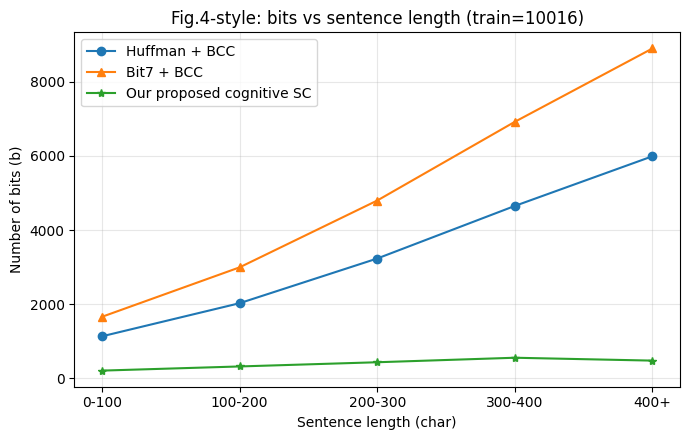

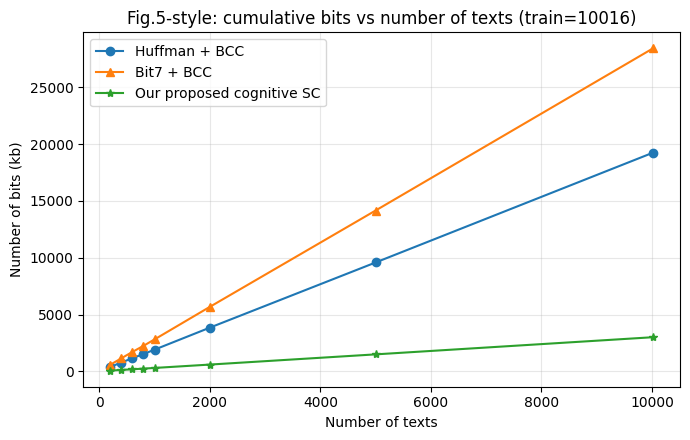


=== Average transmitted bits per text ===
Huffman+BCC: 1921.8 bits
Bit7+BCC   : 2838.9 bits
Ours+BCC   : 299.8 bits

=== Reduction vs baselines ===
vs Huffman: 84.4%
vs Bit7   : 89.4%

=== Health check ===
ours_bcc==0: 1158/10016 (11.56%)


In [20]:
import os, json, math, re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = "/content/webnlg_kg_text2kg_1000"

PAIRS_PATH = os.path.join(BASE_DIR, "pairs_train_10016.json")
# ✅ B/C 결과: 문장별 semantic symbol 개수(=보내는 triple 수)를 여기서 읽음
ABSTR_SSC_PATH = os.path.join(BASE_DIR, "semantic_symbol_abstraction_ssc_train_10016.json")
# ✅ L(SSC bits/triple) 얻기 위한 KG SSC
KG_SSC_PATH = os.path.join(BASE_DIR, "kg_triples_ssc_train_10016.json")

assert os.path.exists(PAIRS_PATH), PAIRS_PATH
assert os.path.exists(ABSTR_SSC_PATH), ABSTR_SSC_PATH
assert os.path.exists(KG_SSC_PATH), KG_SSC_PATH

# ----------------------------
# Config
# ----------------------------
REP = 3  # repetition BCC (rep=3이면 3배 전송)
USE_UNICODE_BYTES_FOR_BIT7 = False

# ----------------------------
# Load data
# ----------------------------
with open(PAIRS_PATH, "r", encoding="utf-8") as f:
    pairs = json.load(f)

with open(ABSTR_SSC_PATH, "r", encoding="utf-8") as f:
    abstr = json.load(f)

with open(KG_SSC_PATH, "r", encoding="utf-8") as f:
    kg_ssc = json.load(f)

# idx 매핑 (int로 통일)
def to_int_idx(x):
    try:
        return int(x)
    except:
        return x

pairs_by_idx = {to_int_idx(ex.get("idx", i)): ex for i, ex in enumerate(pairs)}
abstr_by_idx = {to_int_idx(ex.get("idx")): ex for ex in abstr if "idx" in ex}

# SSC bit length L (triple당 비트 수)
L = len(kg_ssc[0]["bits"])
print("SSC bits per triple L =", L)
print("pairs:", len(pairs), "abstr:", len(abstr))

# ----------------------------
# Huffman coding utilities (character-level)
# ----------------------------
class HuffNode:
    __slots__ = ("ch","freq","left","right")
    def __init__(self, ch=None, freq=0, left=None, right=None):
        self.ch = ch
        self.freq = freq
        self.left = left
        self.right = right

def build_huffman_code_lengths(char_freq: dict):
    import heapq
    heap = []
    uid = 0
    for ch, fr in char_freq.items():
        heapq.heappush(heap, (fr, uid, HuffNode(ch=ch, freq=fr)))
        uid += 1

    if len(heap) == 1:
        fr, _, node = heap[0]
        return {node.ch: 1}

    while len(heap) > 1:
        fr1, _, n1 = heapq.heappop(heap)
        fr2, _, n2 = heapq.heappop(heap)
        merged = HuffNode(ch=None, freq=fr1+fr2, left=n1, right=n2)
        heapq.heappush(heap, (merged.freq, uid, merged))
        uid += 1

    root = heap[0][2]
    lengths = {}

    def dfs(node, depth):
        if node.ch is not None:
            lengths[node.ch] = max(depth, 1)
            return
        dfs(node.left, depth+1)
        dfs(node.right, depth+1)

    dfs(root, 0)
    return lengths

# 코퍼스 기반 Huffman codebook 생성
all_text = "".join([ex["text"] for ex in pairs])
freq = Counter(all_text)
huff_len = build_huffman_code_lengths(freq)

def huffman_bits(text: str) -> int:
    return int(sum(huff_len.get(ch, 8) for ch in text))  # unseen 대비 8bit fallback

def bit7_bits(text: str) -> int:
    if USE_UNICODE_BYTES_FOR_BIT7:
        return int(8 * len(text.encode("utf-8")))
    else:
        return int(7 * len(text))

def ours_bits_from_abstr(idx: int) -> int:
    item = abstr_by_idx.get(idx)
    if item is None:
        return 0
    # ✅ 우리가 보내는 건 semantic_symbols_ssc의 개수 * L
    n_tr = len(item.get("semantic_symbols_ssc", []))
    return int(n_tr * L)

# ----------------------------
# Compute per-sample bits
# ----------------------------
rows = []
for ex in pairs:
    idx = to_int_idx(ex.get("idx"))
    text = ex["text"]
    n_chars = len(text)

    b_bit7  = bit7_bits(text)
    b_huff  = huffman_bits(text)
    b_ours  = ours_bits_from_abstr(idx)

    rows.append({
        "idx": idx,
        "chars": n_chars,
        "bit7_bcc": b_bit7 * REP,
        "huff_bcc": b_huff * REP,
        "ours_bcc": b_ours * REP,  # ours도 동일 BCC 적용 (공정 비교)
    })

print("Computed rows:", len(rows))

# ----------------------------
# Figure 4: bits vs sentence length (char bins)
# ----------------------------
bins = [(0,100), (100,200), (200,300), (300,400), (400,10**9)]
bin_labels = ["0-100","100-200","200-300","300-400","400+"]

def avg_in_bin(key):
    out = []
    for (lo,hi) in bins:
        vals = [r[key] for r in rows if (r["chars"] >= lo and r["chars"] < hi)]
        out.append(float(np.mean(vals)) if len(vals) else np.nan)
    return out

y_huff = avg_in_bin("huff_bcc")
y_bit7 = avg_in_bin("bit7_bcc")
y_ours = avg_in_bin("ours_bcc")

plt.figure(figsize=(7,4.5))
x = np.arange(len(bin_labels))
plt.plot(x, y_huff, marker="o", label="Huffman + BCC")
plt.plot(x, y_bit7, marker="^", label="Bit7 + BCC")
plt.plot(x, y_ours, marker="*", label="Our proposed cognitive SC")
plt.xticks(x, bin_labels)
plt.xlabel("Sentence length (char)")
plt.ylabel("Number of bits (b)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Fig.4-style: bits vs sentence length (train=10016)")
plt.tight_layout()
plt.show()

# ----------------------------
# Figure 5: cumulative bits vs number of texts
# ----------------------------
# ✅ 10016이니까 논문 느낌으로 더 촘촘히도 가능
counts = [200, 400, 600, 800, 1000, 2000, 5000, 10016]
counts = [c for c in counts if c <= len(rows)]

def cumulative_kb(key, n):
    total_bits = sum(r[key] for r in rows[:n])  # 앞에서 n개
    return float(total_bits / 1000.0)  # kb (논문 축 관례)

y2_huff = [cumulative_kb("huff_bcc", n) for n in counts]
y2_bit7 = [cumulative_kb("bit7_bcc", n) for n in counts]
y2_ours = [cumulative_kb("ours_bcc", n) for n in counts]

plt.figure(figsize=(7,4.5))
plt.plot(counts, y2_huff, marker="o", label="Huffman + BCC")
plt.plot(counts, y2_bit7, marker="^", label="Bit7 + BCC")
plt.plot(counts, y2_ours, marker="*", label="Our proposed cognitive SC")
plt.xlabel("Number of texts")
plt.ylabel("Number of bits (kb)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Fig.5-style: cumulative bits vs number of texts (train=10016)")
plt.tight_layout()
plt.show()

# ----------------------------
# Quick print: 평균 절감률
# ----------------------------
avg_huff = float(np.mean([r["huff_bcc"] for r in rows]))
avg_bit7 = float(np.mean([r["bit7_bcc"] for r in rows]))
avg_ours = float(np.mean([r["ours_bcc"] for r in rows]))

print("\n=== Average transmitted bits per text ===")
print(f"Huffman+BCC: {avg_huff:.1f} bits")
print(f"Bit7+BCC   : {avg_bit7:.1f} bits")
print(f"Ours+BCC   : {avg_ours:.1f} bits")

print("\n=== Reduction vs baselines ===")
print(f"vs Huffman: {100*(1-avg_ours/avg_huff):.1f}%")
print(f"vs Bit7   : {100*(1-avg_ours/avg_bit7):.1f}%")

# ----------------------------
# Health check: ours가 0이 너무 많은지
# ----------------------------
zero_ours = sum(1 for r in rows if r["ours_bcc"] == 0)
print("\n=== Health check ===")
print(f"ours_bcc==0: {zero_ours}/{len(rows)} ({100*zero_ours/len(rows):.2f}%)")


Fig.6 + Fig.7 semantic similarity score, BLEU score

device: cuda
SSC bits per triple: 33


Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

valid (non-empty ours): 8858 / 10016
p=0.00 | ours empty rate=0.00% | sim(ours)=0.8209
p=0.05 | ours empty rate=0.00% | sim(ours)=0.8209
p=0.10 | ours empty rate=0.00% | sim(ours)=0.8170
p=0.15 | ours empty rate=0.00% | sim(ours)=0.8003
p=0.20 | ours empty rate=0.00% | sim(ours)=0.7805

Done sweep.


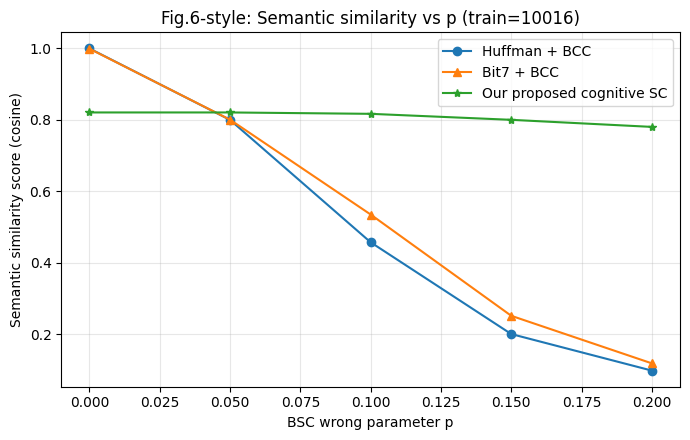

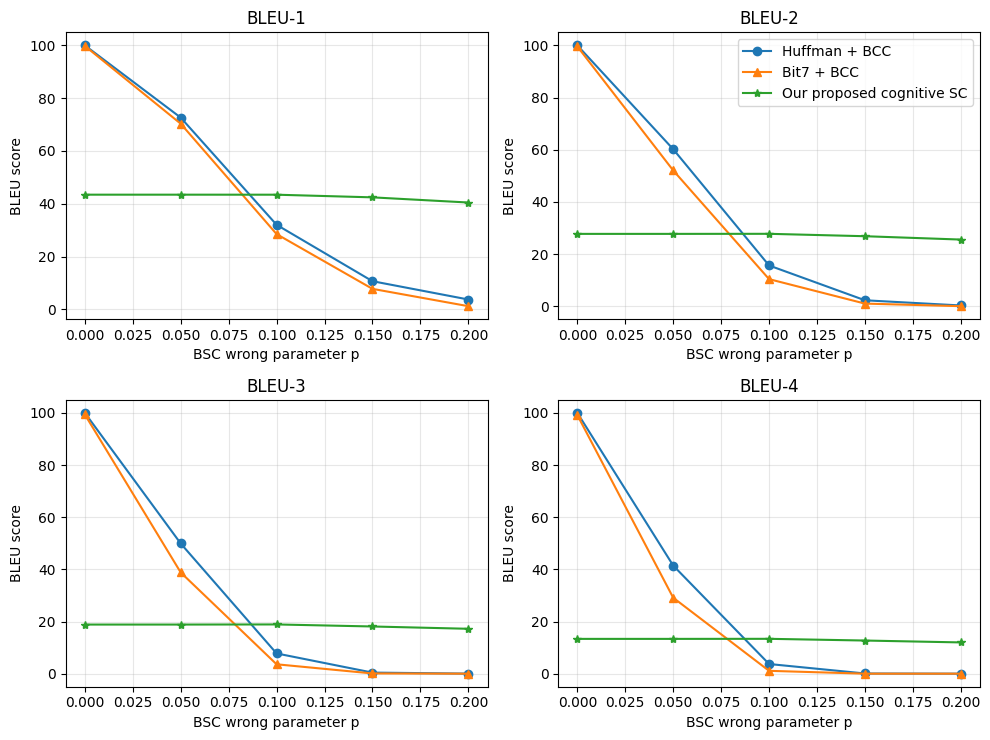

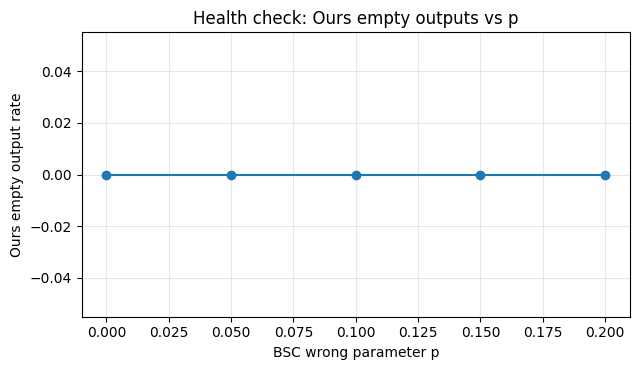

In [21]:
!pip -q install -U sentence-transformers

import os, json, random, math, re
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import Counter

# -------------------------
# Config
# -------------------------
BASE_DIR = "/content/webnlg_kg_text2kg_1000"
PAIRS_PATH      = os.path.join(BASE_DIR, "pairs_train_10016.json")
ABSTR_SSC_PATH  = os.path.join(BASE_DIR, "semantic_symbol_abstraction_ssc_train_10016.json")
KG_SSC_PATH     = os.path.join(BASE_DIR, "kg_triples_ssc_train_10016.json")
T5_DIR          = os.path.join(BASE_DIR, "t5_kg2text_pt")

assert os.path.exists(PAIRS_PATH), PAIRS_PATH
assert os.path.exists(ABSTR_SSC_PATH), ABSTR_SSC_PATH
assert os.path.exists(KG_SSC_PATH), KG_SSC_PATH
assert os.path.exists(T5_DIR), T5_DIR

REP = 3
P_LIST = [0.0, 0.05, 0.10, 0.15, 0.20]
N_SAMPLES = 200               # 120~500 추천
FILTER_EMPTY_OURS = True      # ours가 empty인 샘플 제외(공정성/안정성 ↑)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -------------------------
# Load data
# -------------------------
with open(PAIRS_PATH, "r", encoding="utf-8") as f:
    pairs = json.load(f)

with open(ABSTR_SSC_PATH, "r", encoding="utf-8") as f:
    abstr = json.load(f)

with open(KG_SSC_PATH, "r", encoding="utf-8") as f:
    kg_ssc = json.load(f)

def to_int_idx(x):
    try: return int(x)
    except: return x

pairs_by_idx = {to_int_idx(ex.get("idx", i)): ex for i, ex in enumerate(pairs)}
abstr_by_idx = {to_int_idx(ex.get("idx")): ex for ex in abstr if "idx" in ex}

L = len(kg_ssc[0]["bits"])
print("SSC bits per triple:", L)

# KG codebook (for correction)
KG_CODES = np.array([it["bits"] for it in kg_ssc], dtype=np.int8)
bits2triple = {}
for it in kg_ssc:
    tri = it.get("triple")
    if not tri:
        # fallback for older format
        tri = [it.get("h"), it.get("r"), it.get("t")]
    bits2triple[tuple(it["bits"])] = tri

# -------------------------
# T5 KG2Text
# (평가 셀과 동일: paper-style linearize)
# -------------------------
from transformers import T5TokenizerFast, T5ForConditionalGeneration
t5_tok = T5TokenizerFast.from_pretrained(T5_DIR)
t5 = T5ForConditionalGeneration.from_pretrained(T5_DIR).to(device)
t5.eval()

MAX_SRC_LEN = 256

def clean_obj(x: str) -> str:
    x = str(x).replace("_", " ").replace('"', "").strip()
    if "^^<" in x:
        x = x.split("^^<")[0].strip()
    x = re.sub(r"\s+"," ", x)
    return x

def linearize_paper_style(triples):
    trs=[]
    for tri in triples:
        if isinstance(tri, dict) and "triple" in tri:
            tri = tri["triple"]
        if not isinstance(tri, (list, tuple)) or len(tri) < 3:
            continue
        h,r,t = tri[0], tri[1], tri[2]
        trs.append((clean_obj(h), clean_obj(r), clean_obj(t)))

    if not trs:
        return ""
    head_counts = Counter([h for h,_,_ in trs])
    main_head = head_counts.most_common(1)[0][0]
    main_pairs = [(r,t) for (h,r,t) in trs if h == main_head]
    if not main_pairs:
        main_head = trs[0][0]
        main_pairs = [(trs[0][1], trs[0][2])]
    rt = ", ".join([f"{r} {t}" for (r,t) in main_pairs])
    return f"kg2text: {main_head} {rt}"

@torch.no_grad()
def kg2text_generate(triples, max_new_tokens=80):
    src = linearize_paper_style(triples)
    if not src.strip():
        return ""
    inputs = t5_tok(src, return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN).to(device)
    y = t5.generate(**inputs, num_beams=1, do_sample=False, max_new_tokens=max_new_tokens)
    return t5_tok.decode(y[0], skip_special_tokens=True)

# -------------------------
# Channel: BSC + repetition
# -------------------------
def bsc_flip_bits(bits: np.ndarray, p: float) -> np.ndarray:
    flip = (np.random.rand(bits.size) < p).astype(np.int8)
    return (bits ^ flip).astype(np.int8)

def rep_encode(bits: np.ndarray, rep=3):
    return np.repeat(bits, rep).astype(np.int8)

def rep_decode(bits: np.ndarray, rep=3):
    n = (bits.size // rep) * rep
    bits = bits[:n].reshape(-1, rep)
    return (np.sum(bits, axis=1) >= (rep/2)).astype(np.int8)

# correction: nearest neighbor in KG codebook (Hamming min)
def correction_algo(o: np.ndarray) -> np.ndarray:
    dists = np.sum(KG_CODES != o[None, :], axis=1)
    return KG_CODES[int(np.argmin(dists))]

# -------------------------
# Baselines: Bit7 + Huffman
# -------------------------
def bit7_encode(text: str) -> np.ndarray:
    arr=[]
    for ch in text:
        v = ord(ch) & 0x7F
        arr.extend([(v >> k) & 1 for k in range(6,-1,-1)])
    return np.array(arr, dtype=np.int8)

def bit7_decode(bits: np.ndarray) -> str:
    n = (bits.size // 7) * 7
    bits = bits[:n].reshape(-1, 7)
    chars=[]
    for b in bits:
        v=0
        for i in range(7):
            v = (v << 1) | int(b[i])
        chars.append(chr(v))
    return "".join(chars)

def build_huffman_codebook(text_corpus: str):
    import heapq
    freq = Counter(text_corpus)
    heap=[]
    uid=0
    for ch,fr in freq.items():
        heapq.heappush(heap,(fr,uid,(ch,None,None)))
        uid+=1
    if len(heap)==1:
        ch = heap[0][2][0]
        return {ch:"0"}
    while len(heap)>1:
        fr1,_,n1=heapq.heappop(heap)
        fr2,_,n2=heapq.heappop(heap)
        heapq.heappush(heap,(fr1+fr2,uid,(None,n1,n2))); uid+=1
    root=heap[0][2]
    codes={}
    def dfs(node,prefix):
        ch,left,right = node
        if ch is not None:
            codes[ch]=prefix or "0"
            return
        dfs(left,prefix+"0")
        dfs(right,prefix+"1")
    dfs(root,"")
    return codes

all_text = "".join([ex["text"] for ex in pairs])
huff_code = build_huffman_codebook(all_text)

class HuffTrie:
    def __init__(self): self.root={}
    def add(self,ch,code):
        cur=self.root
        for c in code:
            cur=cur.setdefault(c,{})
        cur["$"]=ch
    def decode(self,bits):
        cur=self.root
        out=[]
        for b in bits:
            cur=cur.get("1" if b else "0", {})
            if "$" in cur:
                out.append(cur["$"])
                cur=self.root
        return "".join(out)

trie = HuffTrie()
for ch,code in huff_code.items():
    trie.add(ch,code)

def huff_encode(text: str) -> np.ndarray:
    bits=[]
    for ch in text:
        code = huff_code.get(ch)
        if code is None:
            code = format(ord(ch)&0xFF, "08b")
        bits.extend([1 if c=="1" else 0 for c in code])
    return np.array(bits, dtype=np.int8)

def huff_decode(bits: np.ndarray) -> str:
    return trie.decode(bits.tolist())

def bit7_baseline_reconstruct(text: str, p: float, rep=3):
    bits = bit7_encode(text)
    tx = rep_encode(bits, rep=rep)
    rx = bsc_flip_bits(tx, p)
    dec = rep_decode(rx, rep=rep)
    return bit7_decode(dec)

def huff_baseline_reconstruct(text: str, p: float, rep=3):
    bits = huff_encode(text)
    tx = rep_encode(bits, rep=rep)
    rx = bsc_flip_bits(tx, p)
    dec = rep_decode(rx, rep=rep)
    return huff_decode(dec)

# -------------------------
# OURS: (semantic_symbols_ssc bits) -> channel -> correction -> triples -> T5
# -------------------------
def ours_reconstruct(idx: int, p: float, rep=3):
    item = abstr_by_idx.get(idx)
    if item is None:
        return ""

    syms = item.get("semantic_symbols_ssc", [])
    if not syms:
        return ""

    final_triples = []
    for s in syms:
        b = s.get("bits")
        if b is None:
            continue
        code = np.array(b, dtype=np.int8)

        tx = rep_encode(code, rep=rep)
        rx = bsc_flip_bits(tx, p)
        dec = rep_decode(rx, rep=rep)
        corr = correction_algo(dec)

        tri_rec = bits2triple.get(tuple(corr.tolist()))
        if tri_rec is not None and len(tri_rec) >= 3:
            final_triples.append([tri_rec[0], tri_rec[1], tri_rec[2]])

    if not final_triples:
        return ""

    return kg2text_generate(final_triples)

# -------------------------
# Sentence similarity embeddings (cosine)
# -------------------------
from sentence_transformers import SentenceTransformer
emb_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

def embed_sentences(texts):
    return emb_model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)

def cosine_sim(a, b):
    return np.sum(a*b, axis=1)

# -------------------------
# BLEU-1..4 (stable)
# -------------------------
def ngrams(tokens, n):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def corpus_bleu_n(preds, refs, n):
    total_clipped = 0
    total_count = 0
    pred_len = 0
    ref_len = 0

    for ptxt, rtxt in zip(preds, refs):
        ptok = ptxt.strip().split()
        rtok = rtxt.strip().split()
        pred_len += len(ptok)
        ref_len  += len(rtok)

        if len(ptok) < n:
            continue

        p_ng = Counter(ngrams(ptok, n))
        r_ng = Counter(ngrams(rtok, n))
        clipped = sum((p_ng & r_ng).values())
        count = sum(p_ng.values())

        total_clipped += clipped
        total_count += count

    prec = (total_clipped / total_count) if total_count > 0 else 0.0

    if pred_len == 0:
        bp = 0.0
    elif pred_len > ref_len:
        bp = 1.0
    else:
        bp = math.exp(1 - (ref_len / max(pred_len, 1)))

    return 100.0 * bp * prec

# -------------------------
# Sample selection (공정하게: ours가 비어있는 샘플 제외 옵션)
# -------------------------
random.seed(7)
all_idxs = [to_int_idx(ex.get("idx", i)) for i, ex in enumerate(pairs)]

if FILTER_EMPTY_OURS:
    valid_idxs = [idx for idx in all_idxs if abstr_by_idx.get(idx, {}).get("semantic_symbols_ssc")]
    print("valid (non-empty ours):", len(valid_idxs), "/", len(all_idxs))
else:
    valid_idxs = all_idxs

eval_idxs = random.sample(valid_idxs, min(N_SAMPLES, len(valid_idxs)))
eval_samples = [pairs_by_idx[idx] for idx in eval_idxs]

# -------------------------
# Run sweep
# -------------------------
sim_curve = {"huff":[], "bit7":[], "ours":[]}
bleu_curve = {"huff":[[],[],[],[]], "bit7":[[],[],[],[]], "ours":[[],[],[],[]]}
empty_rates = []

def run_one_p(p):
    gold_texts, rec_huff, rec_bit7, rec_ours = [], [], [], []

    for ex in eval_samples:
        idx = to_int_idx(ex.get("idx"))
        gold = ex["text"]
        gold_texts.append(gold)

        rec_huff.append(huff_baseline_reconstruct(gold, p, rep=REP))
        rec_bit7.append(bit7_baseline_reconstruct(gold, p, rep=REP))
        rec_ours.append(ours_reconstruct(idx, p, rep=REP))

    # similarity
    eg = embed_sentences(gold_texts)
    eh = embed_sentences(rec_huff)
    eb = embed_sentences(rec_bit7)
    eo = embed_sentences(rec_ours)

    sim_h = float(np.mean(cosine_sim(eg, eh)))
    sim_b = float(np.mean(cosine_sim(eg, eb)))
    sim_o = float(np.mean(cosine_sim(eg, eo)))

    # BLEU-1..4
    b_h = [corpus_bleu_n(rec_huff, gold_texts, n) for n in [1,2,3,4]]
    b_b = [corpus_bleu_n(rec_bit7, gold_texts, n) for n in [1,2,3,4]]
    b_o = [corpus_bleu_n(rec_ours, gold_texts, n) for n in [1,2,3,4]]

    empty_rate = sum([1 for s in rec_ours if s.strip()==""]) / len(rec_ours)
    return (sim_h, sim_b, sim_o), b_h, b_b, b_o, empty_rate

for p in P_LIST:
    (s_h, s_b, s_o), bh, bb, bo, er = run_one_p(p)
    sim_curve["huff"].append(s_h)
    sim_curve["bit7"].append(s_b)
    sim_curve["ours"].append(s_o)
    for k in range(4):
        bleu_curve["huff"][k].append(bh[k])
        bleu_curve["bit7"][k].append(bb[k])
        bleu_curve["ours"][k].append(bo[k])
    empty_rates.append(er)
    print(f"p={p:.2f} | ours empty rate={er:.2%} | sim(ours)={s_o:.4f}")

print("\nDone sweep.")

# -------------------------
# Plot Fig.6
# -------------------------
plt.figure(figsize=(7,4.5))
plt.plot(P_LIST, sim_curve["huff"], marker="o", label="Huffman + BCC")
plt.plot(P_LIST, sim_curve["bit7"], marker="^", label="Bit7 + BCC")
plt.plot(P_LIST, sim_curve["ours"], marker="*", label="Our proposed cognitive SC")
plt.xlabel("BSC wrong parameter p")
plt.ylabel("Semantic similarity score (cosine)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Fig.6-style: Semantic similarity vs p (train=10016)")
plt.tight_layout()
plt.show()

# -------------------------
# Plot Fig.7 (BLEU-1..4 in 2x2)
# -------------------------
titles = ["BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4"]
plt.figure(figsize=(10,7.5))
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.plot(P_LIST, bleu_curve["huff"][i], marker="o", label="Huffman + BCC")
    ax.plot(P_LIST, bleu_curve["bit7"][i], marker="^", label="Bit7 + BCC")
    ax.plot(P_LIST, bleu_curve["ours"][i], marker="*", label="Our proposed cognitive SC")
    ax.set_title(titles[i])
    ax.set_xlabel("BSC wrong parameter p")
    ax.set_ylabel("BLEU score")
    ax.grid(True, alpha=0.3)
    if i == 1:
        ax.legend(loc="best")
plt.tight_layout()
plt.show()

# -------------------------
# Health check: empty output rate
# -------------------------
plt.figure(figsize=(6.5,3.8))
plt.plot(P_LIST, empty_rates, marker="o")
plt.xlabel("BSC wrong parameter p")
plt.ylabel("Ours empty output rate")
plt.grid(True, alpha=0.3)
plt.title("Health check: Ours empty outputs vs p")
plt.tight_layout()
plt.show()
